C:\Users\Aamir Javaid\anaconda3\envs\xai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Aamir Javaid\anaconda3\envs\xai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Train Acc: 91.49%, Val Acc: 62.50%
Epoch 2/10, Train Acc: 93.10%, Val Acc: 56.25%
Epoch 3/10, Train Acc: 94.21%, Val Acc: 68.75%
Epoch 4/10, Train Acc: 94.27%, Val Acc: 81.25%
Epoch 5/10, Train Acc: 95.23%, Val Acc: 81.25%
Epoch 6/10, Train Acc: 94.82%, Val Acc: 81.25%
Epoch 7/10, Train Acc: 95.71%, Val Acc: 81.25%
Epoch 8/10, Train Acc: 94.82%, Val Acc: 87.50%
Epoch 9/10, Train Acc: 95.46%, Val Acc: 87.50%
Epoch 10/10, Train Acc: 96.11%, Val Acc: 87.50%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.54      0.69       234
   PNEUMONIA       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624



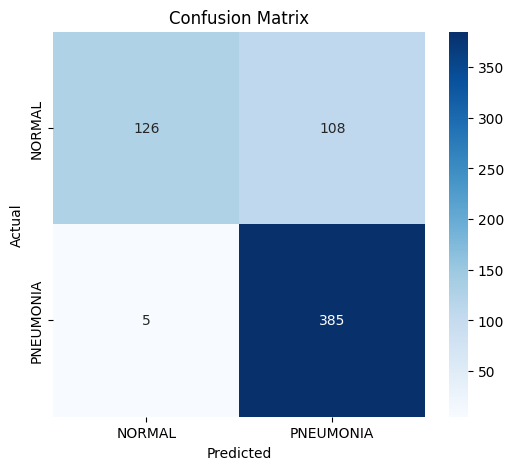

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data paths
data_dir = 'C:/Users/Aamir Javaid/Downloads/XAI_INT/chest_xray'

# Data transforms
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

# Datasets and loaders
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform[x])
    for x in ['train', 'val', 'test']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True)
    for x in ['train', 'val']
}
test_loader = DataLoader(image_datasets['test'], batch_size=32, shuffle=False)

# Class names
class_names = image_datasets['train'].classes

# Load pre-trained ResNet18 and modify
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: NORMAL, PNEUMONIA
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloaders['train']:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    val_loss = 0.0
    val_correct = 0
    val_total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in dataloaders['val']:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Acc: {100*correct/total:.2f}%, "
          f"Val Acc: {100*val_correct/val_total:.2f}%")

# Evaluation
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [2]:
import os
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch
import numpy as np

# 1. Point to your data directories
data_dir = 'C:/Users/Aamir Javaid/Downloads/XAI_INT/chest_xray'
train_dir = os.path.join(data_dir, 'train')

# 2. Load with ImageFolder (we’ll apply ToTensor only so we can inspect raw pixel stats)
train_ds = datasets.ImageFolder(train_dir, transform=ToTensor())

# 3. Basic structure
print(f"→ Classes: {train_ds.classes}")            # ['NORMAL', 'PNEUMONIA']
print(f"→ Total training images: {len(train_ds)}") 

# 4. Examine image shapes & data types
shapes = [img.shape for img, _ in train_ds]
print("→ Unique image shapes:", sorted(set(shapes)))
dtypes = sorted({img.dtype for img, _ in train_ds})
print("→ Pixel data types:", dtypes)

# 5. Compute per-channel mean & std
loader = DataLoader(train_ds, batch_size=32, shuffle=False)
mean = torch.zeros(3)
std  = torch.zeros(3)
n   = 0

for imgs, _ in loader:
    # imgs: [batch, channels, H, W]
    bs = imgs.size(0)
    imgs = imgs.view(bs, imgs.size(1), -1)    # flatten H×W
    mean += imgs.mean(2).sum(0)               # sum of per-image means
    std  += imgs.std(2).sum(0)                # sum of per-image stds
    n    += bs

mean /= n
std  /= n
print(f"→ Channel means: {mean.numpy()}")
print(f"→ Channel stds:  {std.numpy()}")

# 6. (Optional) Class balance check
from collections import Counter
labels = [label for _, label in train_ds]
print("→ Samples per class:", Counter(labels))


→ Classes: ['NORMAL', 'PNEUMONIA']
→ Total training images: 5216
→ Unique image shapes: [torch.Size([3, 127, 384]), torch.Size([3, 132, 446]), torch.Size([3, 138, 400]), torch.Size([3, 140, 445]), torch.Size([3, 144, 437]), torch.Size([3, 151, 494]), torch.Size([3, 156, 492]), torch.Size([3, 157, 460]), torch.Size([3, 163, 482]), torch.Size([3, 164, 399]), torch.Size([3, 167, 480]), torch.Size([3, 168, 438]), torch.Size([3, 172, 428]), torch.Size([3, 173, 448]), torch.Size([3, 175, 461]), torch.Size([3, 177, 557]), torch.Size([3, 178, 407]), torch.Size([3, 178, 455]), torch.Size([3, 178, 483]), torch.Size([3, 179, 438]), torch.Size([3, 180, 452]), torch.Size([3, 182, 453]), torch.Size([3, 186, 486]), torch.Size([3, 187, 445]), torch.Size([3, 188, 499]), torch.Size([3, 189, 490]), torch.Size([3, 190, 438]), torch.Size([3, 191, 486]), torch.Size([3, 194, 564]), torch.Size([3, 196, 494]), torch.Size([3, 198, 500]), torch.Size([3, 199, 445]), torch.Size([3, 200, 462]), torch.Size([3, 206, 

RuntimeError: stack expects each tensor to be equal size, but got [3, 1858, 2090] at entry 0 and [3, 1152, 1422] at entry 1

In [3]:
from torchvision import transforms
import torchvision.transforms.functional as F
import random

def apply_clahe(img):
    # Convert back to PIL, apply CLAHE on each channel, convert to tensor
    import numpy as np
    from PIL import Image, ImageOps
    img_pil = transforms.ToPILImage()(img)
    # CLAHE via PIL’s ImageOps
    # Note: PIL doesn’t have CLAHE built-in; you can use OpenCV or skimage if available
    return transforms.ToTensor()(img_pil)

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    # 50% chance of basic contrast jitter
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.1, contrast=0.5)
    ], p=0.5),
    # 30% chance of more extreme contrast jitter
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=1.0)
    ], p=0.3),
    # Optional: 20% chance of CLAHE (if you implement via cv2 or skimage)
    transforms.RandomApply([transforms.Lambda(lambda img: apply_clahe(img))], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [6]:
import glob
import os

# point this at your folder
image_dir = r'C:/Users/Aamir Javaid/Downloads/XAI_INT/chest_xray'

# recursively grab every .png under that directory
image_paths = glob.glob(os.path.join(image_dir, '**', '*.png'), recursive=True)

print(f"Found {len(image_paths)} images")


Found 0 images


In [7]:
from PIL import Image

# e.g. sizes = [(w,h), …]
sizes = [Image.open(p).size for p in image_paths]


# Initial statistics

In [9]:
import os, glob
from PIL import Image
import numpy as np

# 1. Grab all images (adjust extensions as needed)
root = r"C:/Users/Aamir Javaid/Downloads/XAI_INT/chest_xray"
image_paths = glob.glob(os.path.join(root, "**", "*.jpg"),   recursive=True) \
            + glob.glob(os.path.join(root, "**", "*.jpeg"), recursive=True) \
            + glob.glob(os.path.join(root, "**", "*.png"),  recursive=True)

# 2. Load sizes
sizes = [Image.open(p).size for p in image_paths]  # .size returns (width, height)

# 3. Split into arrays
widths, heights = zip(*sizes)
w = np.array(widths)
h = np.array(heights)

# 4. Compute stats
print("Width  → mean:  {:.1f}, median: {:.1f}, std: {:.1f}".format(
      w.mean(), np.median(w), w.std()))
print("Height → mean:  {:.1f}, median: {:.1f}, std: {:.1f}".format(
      h.mean(), np.median(h), h.std()))

# (Optional) stats on image area in pixels
areas = w * h
print("Area   → mean:  {:.0f}, median: {:.0f}, std: {:.0f}".format(
      areas.mean(), np.median(areas), areas.std()))


Width  → mean:  1327.9, median: 1281.0, std: 363.5
Height → mean:  970.7, median: 888.0, std: 383.4
Area   → mean:  1418909, median: 1136928, std: 970360


In [ ]:
from collections import Counter

size_counts = Counter(sizes)
mode_size, mode_count = size_counts.most_common(1)[0]
outliers = [s for s, cnt in size_counts.items() if s != mode_size]

print("Most common size:", mode_size, "(", mode_count, "images )")
print("Other sizes (to review):", outliers)


## Identify and remove unreadable / missing files

In [10]:
from PIL import Image #Identify and remove unreadable / missing files
valid_paths = []
for p in data_dir:
    try:
        _ = Image.open(p).verify()  # will raise if file’s corrupt
        valid_paths.append(p)
    except Exception:
        print(f"Removing unreadable image: {p}")
# Now work only with valid_paths


Removing unreadable image: C
Removing unreadable image: :
Removing unreadable image: /
Removing unreadable image: U
Removing unreadable image: s
Removing unreadable image: e
Removing unreadable image: r
Removing unreadable image: s
Removing unreadable image: /
Removing unreadable image: A
Removing unreadable image: a
Removing unreadable image: m
Removing unreadable image: i
Removing unreadable image: r
Removing unreadable image:  
Removing unreadable image: J
Removing unreadable image: a
Removing unreadable image: v
Removing unreadable image: a
Removing unreadable image: i
Removing unreadable image: d
Removing unreadable image: /
Removing unreadable image: D
Removing unreadable image: o
Removing unreadable image: w
Removing unreadable image: n
Removing unreadable image: l
Removing unreadable image: o
Removing unreadable image: a
Removing unreadable image: d
Removing unreadable image: s
Removing unreadable image: /
Removing unreadable image: X
Removing unreadable image: A
Removing unrea

Corrupt files found: []
Unique image sizes (pre-resize): {(976, 544), (1994, 1839), (848, 624), (1416, 816), (1454, 1071), (1488, 984), (880, 576), (1532, 1256), (1794, 1176), (1496, 1333), (1318, 1067), (1630, 1333), (1592, 1041), (1364, 805), (1856, 1496), (1016, 616), (2434, 2376), (1322, 1037), (1328, 968), (1854, 1572), (1562, 1284), (920, 648), (1408, 960), (1712, 1488), (1786, 1437), (1360, 920), (1846, 1488), (1624, 1375), (872, 608), (1232, 1000), (1440, 800), (796, 469), (888, 552), (1400, 1221), (1754, 1341), (840, 512), (1720, 1348), (792, 584), (1360, 776), (1542, 1341), (2096, 1864), (1256, 984), (928, 624), (1850, 1314), (1616, 1147), (1742, 1372), (2000, 1896), (760, 488), (812, 678), (1654, 1259), (1312, 1144), (1272, 928), (1224, 888), (1504, 1171), (1890, 1615), (816, 568), (1736, 1328), (1176, 960), (1256, 840), (928, 480), (2280, 2066), (832, 512), (1240, 752), (1806, 1392), (1400, 704), (1272, 784), (1902, 1854), (1956, 1596), (1216, 1032), (982, 573), (1200, 1024

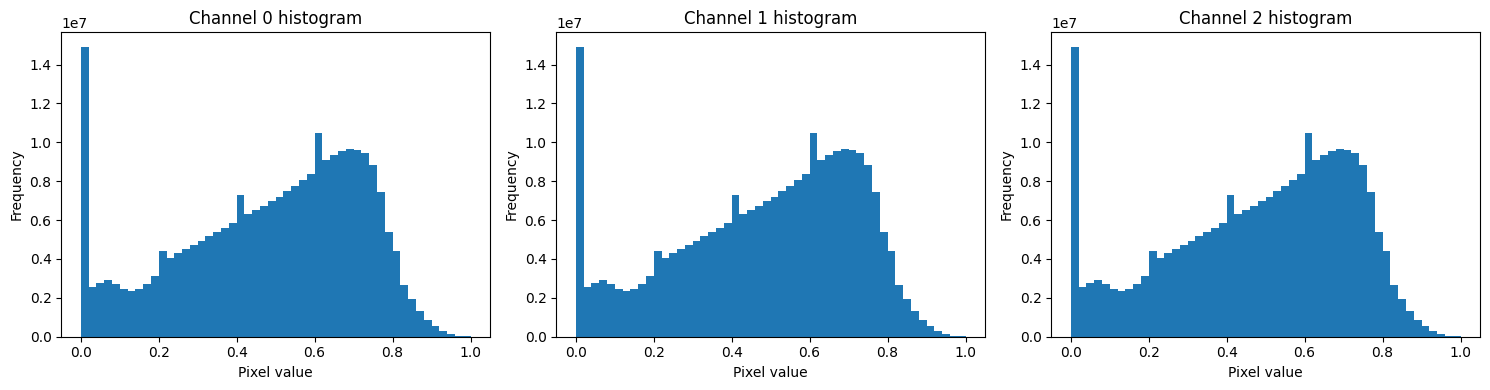

Mode size: (1072, 648) (7 images)
Other sizes (outliers): [(2090, 1858), (1422, 1152), (1810, 1434), (1618, 1279), (1600, 1125), (1974, 1306), (1528, 1013), (1384, 1167), (1450, 1144), (1468, 993), (1724, 1581), (1346, 1044), (1156, 1237), (1740, 1453), (2138, 1928), (1596, 1156), (2102, 1974), (1542, 1152), (1518, 1156), (1612, 1133), (1844, 1438), (1488, 1209), (994, 758), (1750, 1314), (1762, 1430), (1202, 808), (1972, 1719), (1534, 1187), (2148, 1496), (1876, 1893), (1680, 1557), (2172, 1615), (1646, 1124), (2136, 1650), (1372, 1005), (2338, 2025), (1458, 1190), (1854, 1572), (1466, 1109), (2164, 1746), (2010, 1747), (1774, 1546), (1506, 833), (1446, 1310), (1434, 1260), (1554, 1075), (1040, 747), (1426, 1049), (1164, 1021), (1688, 1105), (1642, 1245), (1928, 1303), (1522, 1221), (1666, 1209), (1944, 1367), (1654, 1275), (1678, 1654), (1592, 1272), (1484, 1399), (1804, 1480), (1604, 1179), (1852, 1433), (1766, 1287), (2214, 1974), (1770, 1387), (1870, 1612), (1608, 1175), (1442, 11

In [16]:
import os
from PIL import Image, UnidentifiedImageError
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

data_dir  = 'C:/Users/Aamir Javaid/Downloads/XAI_INT/chest_xray'
train_dir = os.path.join(data_dir, 'train')

# ----------------------------------------------------------------
# 1. Manually walk and record only real images (pre‐resize) sizes
# ----------------------------------------------------------------

sizes = []
corrupt_files = []
valid_exts = ('.jpg', '.jpeg', '.png')

for root, _, files in os.walk(train_dir):
    # skip any __MACOSX folders entirely
    if '__MACOSX' in root:
        continue

    for fname in files:
        # skip macOS resource-fork files
        if fname.startswith('._'):
            continue
        # only attempt known image extensions
        if not fname.lower().endswith(valid_exts):
            continue

        path = os.path.join(root, fname)
        try:
            with Image.open(path) as img:
                sizes.append(img.size)  # PIL reports (width, height)
        except UnidentifiedImageError:
            corrupt_files.append(path)

print("Corrupt files found:", corrupt_files)
print("Unique image sizes (pre-resize):", set(sizes))

# ----------------------------------------------------------------
# 2. Define a filter and build your ImageFolder + DataLoader
# ----------------------------------------------------------------

def is_valid(path: str) -> bool:
    lp = path.lower()
    if '.__macosx' in lp or os.path.basename(lp).startswith('._'):
        return False
    return lp.endswith(valid_exts)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# if torchvision ≥0.9, you can pass is_valid_file directly:
ds = datasets.ImageFolder(    root=train_dir,            # <-- only “NORMAL” & “PNEUMONIA” live here
     transform=transform,
     is_valid_file=is_valid
 )

loader = DataLoader(ds, batch_size=32, shuffle=False)

# ----------------------------------------------------------------
# 3. Compute per-channel mean, std, median
mean   = torch.zeros(3)
std    = torch.zeros(3)
median = torch.zeros(3)
n = 0
all_pixels = [[], [], []]

for imgs, _ in loader:
    bs = imgs.size(0)
    imgs = imgs.view(bs, 3, -1)
    mean += imgs.mean(2).sum(0)
    std  += imgs.std(2).sum(0)
    for c in range(3):
        all_pixels[c].append(imgs[:, c, :].reshape(-1).cpu().numpy())
    n += bs

mean /= n
std  /= n

# **fixed** median assignment
for c in range(3):
    vals = np.concatenate(all_pixels[c])
    median[c] = float(np.median(vals))

print("Channel means: ", mean.tolist())
print("Channel stds:  ", std.tolist())
print("Channel medians:", median.tolist())

# ----------------------------------------------------------------
# 4. Plot histograms for each channel
# ----------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for c, ax in enumerate(axes):
    ax.hist(np.concatenate(all_pixels[c]), bins=50)
    ax.set_title(f'Channel {c} histogram')
    ax.set_xlabel('Pixel value')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------
# 5. Re‐compute outlier sizes (pre‐resize)
# ----------------------------------------------------------------

size_counts = Counter(sizes)
mode_size, mode_count = size_counts.most_common(1)[0]
outliers = [s for s, cnt in size_counts.items() if s != mode_size]

print(f"Mode size: {mode_size} ({mode_count} images)")
print("Other sizes (outliers):", outliers)


In [ ]:
images = []
for batch_number, (inputs, targets) in enumerate(test_loader):
    images.append(inputs)
images = torch.cat(images, dim=0).detach().cpu().numpy()

In [ ]:
n_rows = 4
n_cols = 10

fig, axs = plt.subplots(n_rows, n_cols, figsize=(2.9*n_cols, n_rows*3.3))
for i in range(n_rows*n_cols):
    axs[i//n_cols][i%n_cols].imshow(images[i].transpose(1,2,0))
plt.grid(visible=False)

In [ ]:
import random

# Helper function to un-normalize and display images
def imshow(img, title):
    img = img.permute(1, 2, 0)  # CHW → HWC
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Load a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Move data back to CPU for visualization
images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

# Display 8 random images from the batch with predictions
plt.figure(figsize=(16, 8))
for idx in range(8):
    plt.subplot(2, 4, idx+1)
    imshow(images[idx], 
           f"True: {class_names[labels[idx]]}\nPred: {class_names[preds[idx]]}")
plt.tight_layout()
plt.show()
